Reference - this code is just modification of https://github.com/dennybritz/reinforcement-learning, https://gist.github.com/kkweon/c8d1caabaf7b43317bc8825c226045d2

In [1]:
%run ../utils/commonImports.py
%run ../utils/tradingImports.py
%matplotlib inline

In [2]:
import gym
import itertools
import matplotlib
import sys
import tensorflow as tf
import collections

matplotlib.style.use('ggplot')

C:\Users\vesely\AppData\Local\conda\conda\envs\crypto\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
from collections import namedtuple
from matplotlib import pyplot as plt

def plot_episode_stats(stats, smoothing_window=10, noshow=False):
    # Plot the episode reward over time
    fig = plt.figure(figsize=(10,5))
    rewards_smoothed = pd.Series(stats.episode_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
    plt.plot(rewards_smoothed)
    plt.xlabel("Episode")
    plt.ylabel("Episode Reward (Smoothed)")
    plt.title("Episode Reward over Time (Smoothed over window size {})".format(smoothing_window))
    if noshow:
        plt.close(fig)
    else:
        plt.show(fig)

    return fig

# Load Data

In [4]:
dataRoot = 'D:\\Dropbox\\My work\\krypl-project\\dataFeatures\\poloniex\\5min'
fileName = 'USDT_BTC_5min_2016-01-01_2017-12-31.tsv'
file = '{dataRoot}\\{fileName}'.format(dataRoot=dataRoot, fileName=fileName)

usdtBtc = pd.read_csv(file, sep='\t').query("date >= '2017-01-01'")\
    .sort_values('date').reset_index().drop('index', axis=1)
usdtBtc = usdtBtc

trainRatio = 0.7
trainSize = int(usdtBtc.shape[0] * trainRatio)
usdtBtcTrain = usdtBtc.iloc[:trainSize]
usdtBtcTest = usdtBtc.iloc[trainSize:].reset_index().drop('index', axis=1)

usdtBtcManagerTrain = CurrencyDataManager(usdtBtcTrain['close'], usdtBtcTrain)
usdtBtcManagerTest = CurrencyDataManager(usdtBtcTest['close'], usdtBtcTest)
wallet = {'usdt': 1000}
contractPair = ContractPair.new('usdt', 'btc')

In [5]:
dataManager = deepcopy(usdtBtcManagerTrain)
exchange = BackTestExchange(dataManager, deepcopy(wallet), 0.0025)

# Dummy Estimators

Just to test learning performance

In [6]:
class DummyPolicyEstimator:
    def predict(self, state):
        return [0.7, 0.1, 0.2] 
    
    def update(self, state, target, action):
        pass

    
class DummyValueEstimator:
    def predict(self, state):
        return 0
    
    def update(self, state, target):
        pass

# Keras perceptron

# Reinforce

In [7]:
from modeling.rl.enviroment import ExchangeEnv

# cols = ['close', 'return', 'return_1', 'return_2', 'zscore_36_return', 'zscore_288_return']

env = ExchangeEnv(
    data=usdtBtcTrain.drop('date', axis=1),
    price_col='close',
    pair=contractPair,
    wallet=wallet,
    fee=0.0025,
    epoch_len=288,
    trade_amount=100
)

In [8]:
from modeling.rl.reinforce import reinforce
from modeling.rl.estimator import MLPPolicyEstimator, MLPValueEstimator

tf.reset_default_graph()

global_step = tf.Variable(0, name="global_step", trainable=False)
policy_estimator = MLPPolicyEstimator(env.observation_space.n, env.action_space.n, [env.observation_space.n])
value_estimator = MLPValueEstimator(env.observation_space.n, [17, 5, 8])

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    stats, episodes = reinforce(env, policy_estimator, value_estimator, 200, discount_factor=1.0)

C:\Users\vesely\AppData\Local\conda\conda\envs\crypto\lib\site-packages\tensorflow\python\ops\gradients_impl.py:97: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Step 286 @ Episode 200/200 (-1.0019810449517497))))

In [9]:
episode_stats = pd.DataFrame(episodes[-1])
for k in episode_stats['debug'].values[0].keys():
    episode_stats[k] = episode_stats['debug'].apply(lambda x: x[k])

In [10]:
episode_stats.query('action < 2')

,state,action,reward,next_state,done,debug,current_value,initial_value,err,open
0,"[[0.0, 0.0, 0.0, -0.14393978239604455, 0.02374...",0,0.0000,"[[0.0, 0.0, 0.0, -0.1620874104773431, 0.023464...",False,"{'current_value': 1000.0, 'initial_value': 100...","1,000.0000","1,000.0000",False,False
1,"[[0.0, 0.0, 0.0, -0.1620874104773431, 0.023464...",0,0.0000,"[[0.0, 0.0, 0.0, -0.17005343185712213, 0.02666...",False,"{'current_value': 1000.0, 'initial_value': 100...","1,000.0000","1,000.0000",False,False
2,"[[0.0, 0.0, 0.0, -0.17005343185712213, 0.02666...",0,0.0000,"[[0.0, 0.0, 0.0, -0.10421474767279354, 0.02636...",False,"{'current_value': 1000.0, 'initial_value': 100...","1,000.0000","1,000.0000",False,False
3,"[[0.0, 0.0, 0.0, -0.10421474767279354, 0.02636...",0,0.0000,"[[0.0, 0.0, 0.0, -0.09272497887726372, 0.02522...",False,"{'current_value': 1000.0, 'initial_value': 100...","1,000.0000","1,000.0000",False,False
4,"[[0.0, 0.0, 0.0, -0.09272497887726372, 0.02522...",0,0.0000,"[[0.0, 0.0, 0.0, -0.19395779985848266, 0.02728...",False,"{'current_value': 1000.0, 'initial_value': 100...","1,000.0000","1,000.0000",False,False
5,"[[0.0, 0.0, 0.0, -0.19395779985848266, 0.02728...",0,0.0000,"[[-0.00567855946235829, 0.0, 0.0, -5.006760337...",False,"{'current_value': 1000.0, 'initial_value': 100...","1,000.0000","1,000.0000",False,False
6,"[[-0.00567855946235829, 0.0, 0.0, -5.006760337...",0,0.0000,"[[0.005710989656712906, -0.00567855946235829, ...",False,"{'current_value': 1000.0, 'initial_value': 100...","1,000.0000","1,000.0000",False,False
7,"[[0.005710989656712906, -0.00567855946235829, ...",0,0.0000,"[[0.0, 0.005710989656712906, -0.00567855946235...",False,"{'current_value': 1000.0, 'initial_value': 100...","1,000.0000","1,000.0000",False,False
9,"[[0.0, 0.0, 0.005710989656712906, -0.139763177...",0,0.0000,"[[-0.00567855946235829, 0.0, 0.0, -3.697237865...",False,"{'current_value': 1000.0, 'initial_value': 100...","1,000.0000","1,000.0000",False,False
10,"[[-0.00567855946235829, 0.0, 0.0, -3.697237865...",0,0.0000,"[[0.005710989616735995, -0.00567855946235829, ...",False,"{'current_value': 1000.0, 'initial_value': 100...","1,000.0000","1,000.0000",False,False


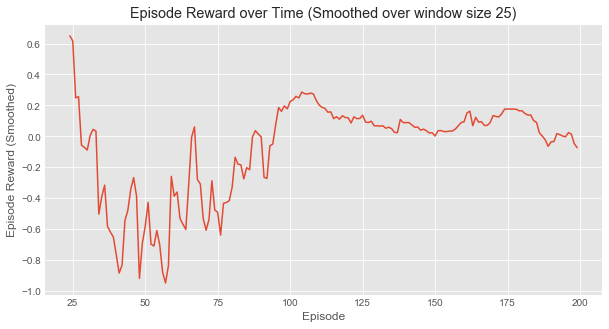

In [11]:
plot_episode_stats(stats, smoothing_window=25);